<a href="https://colab.research.google.com/github/karthik-25/music-generator/blob/main/music_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

# Import Packages & Set Initial Config

In [6]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Download Data

In [9]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 0s 0us/step


In [10]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


# Inspect Midi File

In [11]:
sample_file = filenames[1]
pm = pretty_midi.PrettyMIDI(sample_file)

In [12]:
def display_audio(pm, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # create shorter version of generated waveform
  waveform_short = waveform[:seconds * _SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [13]:
display_audio(pm)

In [50]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [15]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=43, note_name=G2, duration=0.1484
1: pitch=31, note_name=G1, duration=0.1732
2: pitch=55, note_name=G3, duration=0.1549
3: pitch=43, note_name=G2, duration=0.2135
4: pitch=55, note_name=G3, duration=0.2057
5: pitch=31, note_name=G1, duration=0.2083
6: pitch=31, note_name=G1, duration=1.7708
7: pitch=41, note_name=F2, duration=1.9479
8: pitch=53, note_name=F3, duration=2.0547
9: pitch=51, note_name=D#3, duration=0.7331


In [16]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,0.976562,1.125000,0.000000,0.148438
1,31,0.980469,1.153646,0.003906,0.173177
2,55,0.998698,1.153646,0.018229,0.154948
3,43,4.066406,4.279948,3.067708,0.213542
4,55,4.079427,4.285156,0.013021,0.205729


In [18]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G2', 'G1', 'G3', 'G2', 'G3', 'G1', 'G3', 'G2', 'G1', 'F3'],
      dtype='<U3')

In [19]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

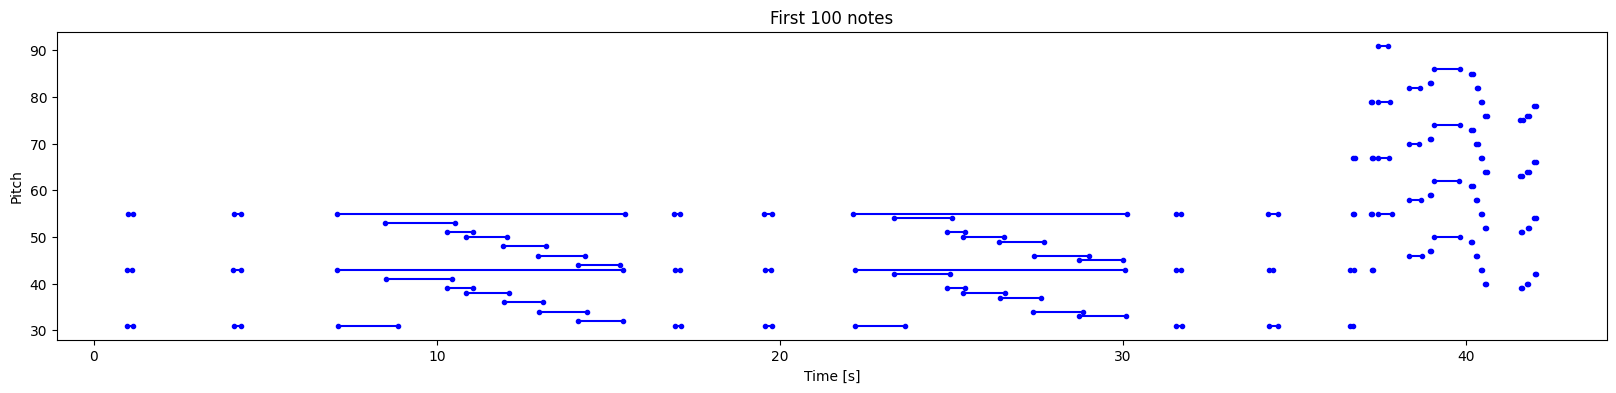

In [20]:
plot_piano_roll(raw_notes, count=100)

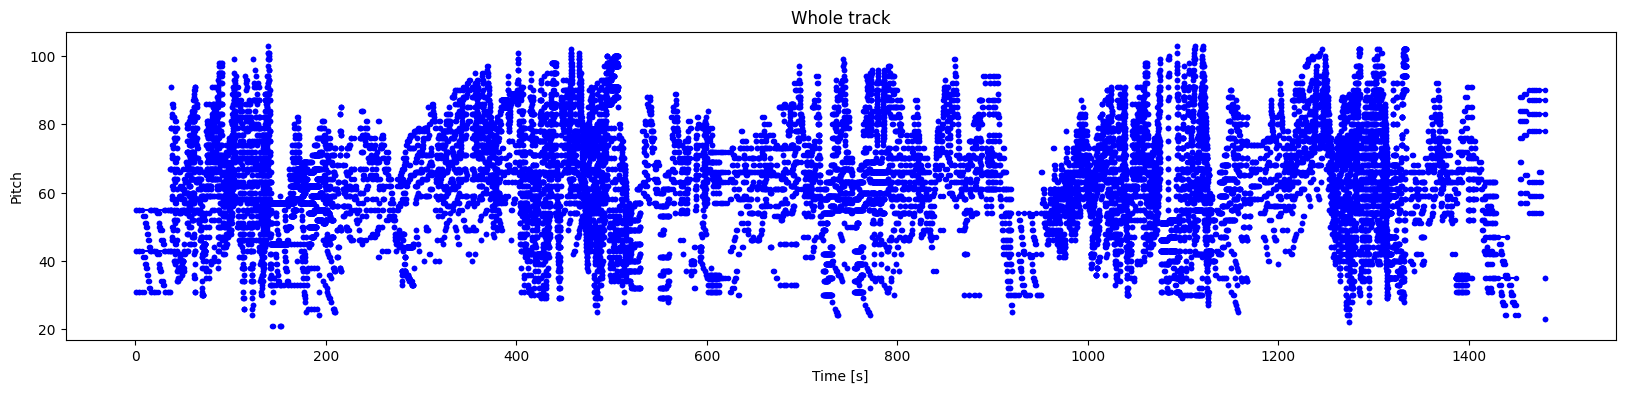

In [21]:
plot_piano_roll(raw_notes)

In [22]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

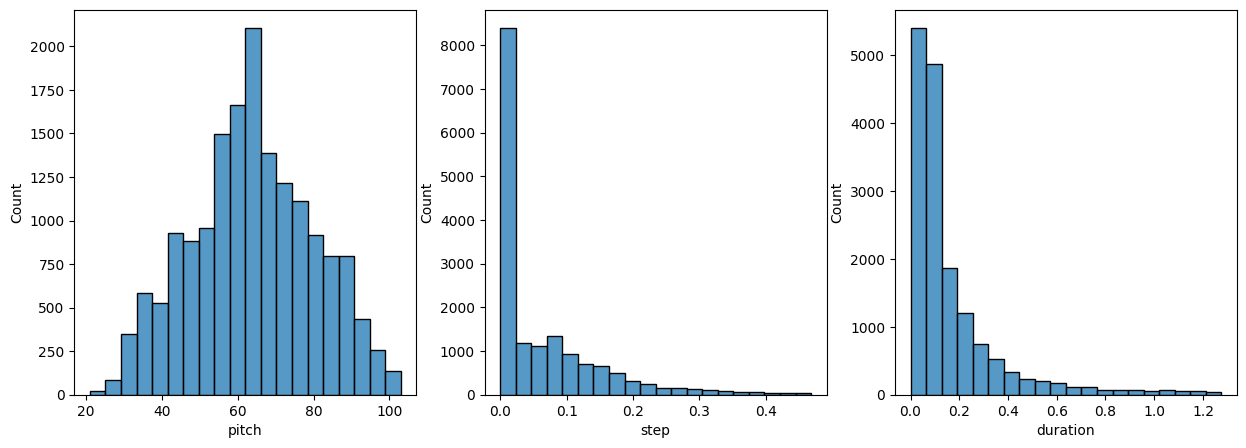

In [23]:
plot_distributions(raw_notes)

# Generate MIDI file

In [24]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [25]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [26]:
display_audio(example_pm)

# Create Training Set

In [27]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [28]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 45712


In [29]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [30]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [31]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [32]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [33]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.3515625  0.         0.04166667]
 [0.4453125  0.01041667 0.03515625]
 [0.484375   0.18880208 0.03645833]
 [0.390625   0.01041667 0.0390625 ]
 [0.4453125  0.1640625  0.03385417]
 [0.3515625  0.00911458 0.0546875 ]
 [0.484375   0.171875   0.04947917]
 [0.390625   0.015625   0.03385417]
 [0.515625   0.16145833 0.05859375]
 [0.421875   0.01822917 0.03125   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=71.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.04557291666666696>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.04817708333333304>}


In [34]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [35]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Create and Train the Model

In [36]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [37]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [38]:
losses = model.evaluate(train_ds, return_dict=True)
losses

713/713 [==============================] - 12s 4ms/step - loss: 5.0588 - duration_loss: 0.1641 - pitch_loss: 4.8534 - step_loss: 0.0413


{'loss': 5.058824062347412,
 'duration_loss': 0.16409532725811005,
 'pitch_loss': 4.8534393310546875,
 'step_loss': 0.0412902757525444}

In [39]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [40]:
model.evaluate(train_ds, return_dict=True)

713/713 [==============================] - 3s 3ms/step - loss: 0.4481 - duration_loss: 0.1641 - pitch_loss: 4.8534 - step_loss: 0.0413


{'loss': 0.44805750250816345,
 'duration_loss': 0.16409532725811005,
 'pitch_loss': 4.8534393310546875,
 'step_loss': 0.0412902757525444}

In [41]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [42]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
713/713 [==============================] - 10s 6ms/step - loss: 0.3446 - duration_loss: 0.0997 - pitch_loss: 4.0881 - step_loss: 0.0404
Epoch 2/50
713/713 [==============================] - 4s 6ms/step - loss: 0.3303 - duration_loss: 0.0954 - pitch_loss: 3.9273 - step_loss: 0.0385
Epoch 3/50
713/713 [==============================] - 5s 7ms/step - loss: 0.3259 - duration_loss: 0.0945 - pitch_loss: 3.8718 - step_loss: 0.0379
Epoch 4/50
713/713 [==============================] - 4s 5ms/step - loss: 0.3233 - duration_loss: 0.0932 - pitch_loss: 3.8529 - step_loss: 0.0374
Epoch 5/50
713/713 [==============================] - 4s 6ms/step - loss: 0.3208 - duration_loss: 0.0919 - pitch_loss: 3.8393 - step_loss: 0.0370
Epoch 6/50
713/713 [==============================] - 5s 7ms/step - loss: 0.3181 - duration_loss: 0.0903 - pitch_loss: 3.8351 - step_loss: 0.0360
Epoch 7/50
713/713 [==============================] - 4s 6ms/step - loss: 0.3153 - duration_loss: 0.0882 - pitch_loss: 3.82

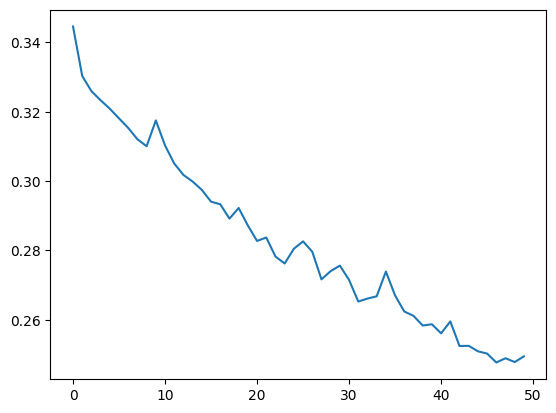

In [43]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Generate Notes

In [44]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [56]:
temperature = 2.0
num_predictions = 240

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for i in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 22ms/step


In [57]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,32,0.472214,0.661839,0.472214,1.134052
1,66,0.045710,1.418329,0.517924,1.936253
2,84,0.021625,1.371552,0.539548,1.911101
3,81,0.000000,1.647244,0.539548,2.186792
4,85,0.000000,1.739144,0.539548,2.278692
5,84,0.000000,1.702552,0.539548,2.242100
6,71,0.001130,1.696055,0.540678,2.236734
7,87,0.165296,1.548324,0.705974,2.254298
8,81,0.038724,1.623565,0.744699,2.368264
9,97,0.145402,1.798989,0.890100,2.689089


In [58]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

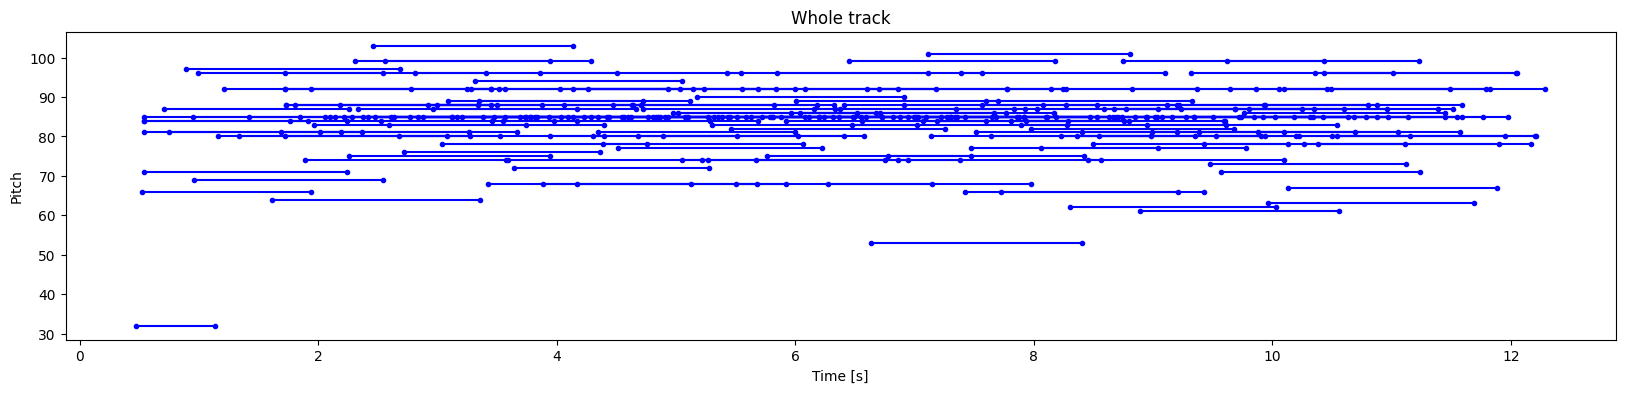

In [59]:
plot_piano_roll(generated_notes)

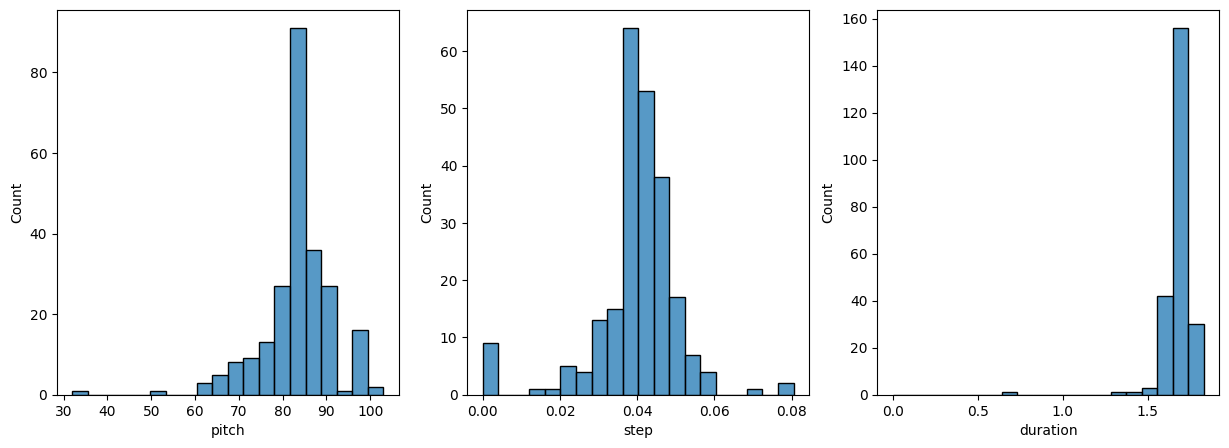

In [60]:
plot_distributions(generated_notes)